# Migrating to AiiDA

:::{admonition} Learning Objectives
:class: learning-objectives

In this section, we will look at how to migrate from running a quantum code from text-based input files, to running it within AiiDA, and understand how AiiDA automates the computation execution and output parsing.

We shall take the example of Quantum ESPRESSO, but the same principles apply to any other code.
This would be a typical command line script to run a Quantum ESPRESSO relaxation:

```console
$ mpirun -np 2 pw.x -in pwx.in > pwx.out
```

:::


## Modularising the inputs

The first step is to modularise the inputs within the `input.in` file, and any pseudo-potential files.

By splitting them into separate components, we can create **re-usable** building blocks for multiple calculations.
We shall also see later how these components can be generated from external data sources, such as databases or web APIs.

![pw-to-aiida](_static/pw-to-aiida.svg){height=500px}


In the diagram above, we have split the input generation into separate entities, handling the different aspects of the calculation and allowing for component re-use.
For a `pw.x` calculation, we need to create the following nodes:

- {term}`Computer`, which describes how we interface with a compute resource
- {term}`Code`, which contains the information on how to execute a single calculation
- `StructureData`, which contains the crystal structure
- `UpfData`, which contains the pseudo-potentials per atomic
- `KpointsData`, which contains the k-point mesh
- `Dict` node, which contains the parameters for the calculation


## The AiiDA Profile

First we need to create a new AiiDA profile.
This is where we store all the nodes generated for a project, and the links between them.


:::{note}

Here we generate a profile with temporary, in-memory storage, which will be destroyed when the Python is restarted.
This is useful for testing, but for a real project, you would create a persistent profile connected to a PostgreSQL database,
using the `verdi quicksetup` command.

:::


In [1]:
from local_module import load_temp_profile

data = load_temp_profile(name="qe-to-aiida")
data

AiiDALoaded(profile=Profile<uuid='5dd18d647c2a43f488d2af795315388e' name='qe-to-aiida'>, computer=None, code=None, pseudos=None, structure=None, cpu_count=2, workdir=PosixPath('/Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_workdir/qe-to-aiida'), pwx_path=PosixPath('/Users/chrisjsewell/opt/miniconda3/envs/aiida-qe-demo/bin/pw.x'))

In [2]:
import aiida

profile = aiida.load_profile("qe-to-aiida")
profile

Profile<uuid='5dd18d647c2a43f488d2af795315388e' name='qe-to-aiida'>

In [3]:
%verdi profile show qe-to-aiida

Report: Profile: qe-to-aiida
PROFILE_UUID: 5dd18d647c2a43f488d2af795315388e
default_user_email: user@email.com
options:
  runner.poll.interval: 1
process_control:
  backend: 'null'
  config: {}
storage:
  backend: sqlite_temp
  config:
    debug: false
    repository_uri: file:///Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_path/.aiida/repository/qe-to-aiida



We can check on the status of the profile using the `verdi status` command.


In [4]:
%verdi -p qe-to-aiida status --no-rmq

 ✔ version:     AiiDA v2.0.4
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_path/.aiida
 ✔ profile:     qe-to-aiida
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_path/.aiida/repository/qe-to-aiida
 ⏺ daemon:      The daemon is not running


We can also check the statistics of the profile's storage.
Before running any simulations, we see that only a single {term}`User` node has been created, which is the default creator of data for the profile.


In [5]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 0
  Nodes:
    count: 0
  Groups:
    count: 0
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 0



## Connecting to a compute resource


An AiiDA {term}`Computer` represents a compute resource, such as a local or remote machine.
It contains information on how to connect to the machine, how to **transport** data to/from the compute resource, and how to **schedule** jobs on it.

In the following we will use a simple `local_direct` computer, which connects to the local machine, and runs the calculations directly, without any scheduler.

AiiDA also has built-in support for a number of {term}`Scheduler`s, including:

- `pbspro`
- `slurm`
- `sge`
- `torque`
- `lsf`

Connections to remote machines can be made using the `SSH` {term}`Transport`, and [aiida-code-registry](https://github.com/aiidateam/aiida-code-registry) provides a collection of example configurations for Swiss based HPC clusters.

We can create the computer using the `verdi computer setup` CLI.


In [6]:
%verdi computer setup \
    --non-interactive \
    --label local_direct \
    --hostname localhost \
    --description "Local computer with direct scheduler" \
    --transport core.local \
    --scheduler core.direct \
    --work-dir {data.workdir} \
    --mpiprocs-per-machine {data.cpu_count}

Success: Computer<1> local_direct created
Report: Note: before the computer can be used, it has to be configured with the command:
Report:   verdi -p qe-to-aiida computer configure core.local local_direct


In [7]:
%verdi computer configure core.local local_direct \
    --non-interactive \
    --safe-interval 0

Report: Configuring computer local_direct for user user@email.com.
Success: local_direct successfully configured for user@email.com


Or we can use the `Computer` class from the `aiida.orm` API module.


In [8]:
created, computer = aiida.orm.Computer.collection.get_or_create(
    label="local_direct",
    description="local computer with direct scheduler",
    hostname="localhost",
    workdir=str(data.workdir),
    transport_type="core.local",
    scheduler_type="core.direct",
)
if created:
    computer.store()
    computer.set_minimum_job_poll_interval(0.0)
    computer.set_default_mpiprocs_per_machine(data.cpu_count)
    computer.configure()
computer

<Computer: local_direct (localhost), pk: 1>

Now we have a computer, ready to run calculations on.


In [9]:
%verdi computer show local_direct

---------------------------  ---------------------------------------------------------------------------------------------------
Label                        local_direct
PK                           1
UUID                         3d034da3-1647-4787-a688-3f559c733c21
Description                  Local computer with direct scheduler
Hostname                     localhost
Transport type               core.local
Scheduler type               core.direct
Work directory               /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_workdir/qe-to-aiida
Shebang                      #!/bin/bash
Mpirun command               mpirun -np {tot_num_mpiprocs}
Default #procs/machine       2
Default memory (kB)/machine
Prepend text
Append text
---------------------------  ---------------------------------------------------------------------------------------------------


## Setting up a code plugin


An AiiDA {term}`Code` represent a single executable, and contain information on how to execute it.
The `Code` node is associated with a specific `Computer`, contains the path to the executable, and is associated with a specific {term}`CalcJob` plugin we shall discuss later.


Again, we can use either the CLI or the API to create a new `Code` node.


In [10]:
%verdi code setup \
    --non-interactive \
    --label pw.x \
    --description "Quantum ESPRESSO pw.x code" \
    --computer local_direct \
    --remote-abs-path {data.pwx_path} \
    --input-plugin quantumespresso.pw \
    --prepend-text "export OMP_NUM_THREADS=1"

Success: Code<1> pw.x@local_direct created


In [11]:
try:
    code = aiida.orm.load_code("pw.x@local_direct")
except aiida.common.NotExistent:
    code = aiida.orm.Code(
        input_plugin_name="quantumespresso.pw",
        remote_computer_exec=[computer, data.pwx_path],
    )
    code.label = "pw.x"
    code.description = "Quantum ESPRESSO pw.x code"
    code.set_prepend_text("export OMP_NUM_THREADS=1")
    code.store()
code

<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 615f6cbc-1c45-47ec-b3a3-4fda3846d948>

Now we have a code ready to run our computations.


In [12]:
%verdi code show pw.x

--------------------  --------------------------------------------------------------
PK                    1
UUID                  615f6cbc-1c45-47ec-b3a3-4fda3846d948
Label                 pw.x
Description           Quantum ESPRESSO pw.x code
Default plugin        quantumespresso.pw
Type                  remote
Remote machine        local_direct
Remote absolute path  /Users/chrisjsewell/opt/miniconda3/envs/aiida-qe-demo/bin/pw.x
Prepend text          export OMP_NUM_THREADS=1
Append text
--------------------  --------------------------------------------------------------


## Deconstructing the input file


Let's now take a look at a typical `pw.x` input file, and how we can convert it to the requisite AiiDA nodes.

:::{note}

Here we are simply generating the inputs from a pre-written input file.
But in practice, you would want to generate the inputs from a Python script, or from a database or web API, as we shall see in the next section.

:::


In [13]:
%cat direct_run/pwx.in

&CONTROL
  calculation = 'relax'
  etot_conv_thr =   2.0000000000d-04
  forc_conv_thr =   1.0000000000d-03
  max_seconds =   86400
  outdir = './out/'
  prefix = 'aiida'
  pseudo_dir = './pseudo/'
  restart_mode = 'from_scratch'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   1.0000000000d-02
  ecutrho =   2.4000000000d+02
  ecutwfc =   3.0000000000d+01
  ibrav = 0
  nat = 2
  nosym = .false.
  ntyp = 1
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
&IONS
/
ATOMIC_SPECIES
Si     28.085 Si.pbe-n-rrkjus_psl.1.0.0.UPF
ATOMIC_POSITIONS angstrom
Si           0.0000000000       0.0000000000       0.0000000000
Si           1.8940738226       1.0935440313       0.7732524001
K_POINTS automatic
5 5 5 0 0 0
CELL_PARAMETERS angstrom
      3.7881476452       0.0000000000       0.0000000000
      1.8940738226       3.2806320940       0.0000000000
      1.894073

To decompose this file into the components we need, we can use the [qe_tools](https://pypi.org/project/qe-tools/) package, which provides a Python API to parse Quantum ESPRESSO input files.


In [14]:
import qe_tools

pw_input = qe_tools.parsers.PwInputFile(open("direct_run/pwx.in").read())
pw_input

We can then generate our AiiDA input {term}`Data` nodes.


In [15]:
structure = aiida.orm.StructureData(cell=pw_input.structure["cell"])
for p, s in zip(pw_input.structure["positions"], pw_input.structure["atom_names"]):
    structure.append_atom(position=p, symbols=s)
structure

<StructureData: uuid: 1980a2ad-f9b1-48d1-bf2b-b97922c95c7c (unstored)>

In [16]:
kpoints = aiida.orm.KpointsData()
kpoints.set_cell_from_structure(structure)
kpoints.set_kpoints_mesh(
    pw_input.k_points["points"],
    offset=pw_input.k_points["offset"],
)
kpoints

<KpointsData: uuid: 45681b3b-cd43-4166-86c8-fb90a1b732ba (unstored)>

In [17]:
# AiiDA will handle assigning file names to generated input files,
# and computing te system type from the structure.
_parameters = pw_input.namelists
for disallowed in ["pseudo_dir", "outdir", "prefix"]:
    _parameters["CONTROL"].pop(disallowed, None)
for disallowed in ["nat", "ntyp"]:
    _parameters["SYSTEM"].pop(disallowed, None)
parameters = aiida.orm.Dict(dict=_parameters)
parameters

<Dict: uuid: c0cb45aa-8b1c-4cc8-a3d6-bf8120050741 (unstored)>

In [18]:
from os.path import abspath

pseudo_si, _ = aiida.orm.UpfData.get_or_create(
    abspath("direct_run/pseudo/Si.pbe-n-rrkjus_psl.1.0.0.UPF")
)
pseudo_si

<UpfData: uuid: 78a976f5-1555-424c-bc0d-012fad7e6d88 (pk: 2)>

## Setting up the inputs for a calculation


Using `verdi plugin list aiida.calculations` we can inspect the full specification for the inputs of the calculation plugin we wish to use.


In [19]:
%verdi plugin list aiida.calculations quantumespresso.pw

Description:

    `CalcJob` implementation for the pw.x code of Quantum ESPRESSO.

Inputs:
                    kpoints:  required  KpointsData       kpoint mesh or kpoint path
                 parameters:  required  Dict              The input parameters that are to be used to construct the input file.
                    pseudos:  required  UpfData, UpfData  A mapping of `UpfData` nodes onto the kind name to which they should apply.
                  structure:  required  StructureData     The input structure.
                       code:  optional  Code              The `Code` to use for this job. This input is required, unless the `remote_ ...
               hubbard_file:  optional  SinglefileData    SinglefileData node containing the output Hubbard parameters from a HpCalcu ...
                   metadata:  optional                    
            parallelization:  optional  Dict              Parallelization options. The following flags are allowed:
npool  : The numb ...
          

Since we already assigned the `quantumespresso.pw` plugin to our `Code` node, we can load it and use the `get_builder` to generate a template for the inputs, known as the `Builder`.

The `Builder` provides us a structured way to add (and validate) the inputs for the calculation.
Below we add the input nodes that we have created for our calculation.


In [20]:
code = aiida.orm.load_code("pw.x@local_direct")
builder = code.get_builder()
builder.structure = structure
builder.parameters = parameters
builder.kpoints = kpoints
builder.pseudos = {"Si": pseudo_si}
builder

Process class: PwCalculation
Inputs:
code: Quantum ESPRESSO pw.x code
kpoints: 'Kpoints mesh: 5x5x5 (+0.0,0.0,0.0)'
metadata:
  options:
    stash: {}
parameters:
  CONTROL:
    calculation: relax
    etot_conv_thr: 0.0002
    forc_conv_thr: 0.001
    max_seconds: 86400
    restart_mode: from_scratch
    tprnfor: true
    tstress: true
    verbosity: high
  ELECTRONS:
    conv_thr: 8.0e-10
    electron_maxstep: 80
    mixing_beta: 0.4
  SYSTEM:
    degauss: 0.01
    ecutrho: 240.0
    ecutwfc: 30.0
    ibrav: 0
    nosym: false
    occupations: smearing
    smearing: cold
pseudos:
  Si: ''
structure: Si


## Running the calculation


AiiDA provides two main ways to run a calculation:

1. Using the `engine.run` functions, which runs the computation directly and waits for it to complete.
2. Using the `engine.submit` function, which submits the calculation to the AiiDA daemon, which can be started in the background and manages the execution of the calculations.


In [21]:
output = aiida.engine.run_get_node(builder)
output.node

<CalcJobNode: uuid: 4f8c9765-c87d-4de9-a78e-42062c034b79 (pk: 6) (aiida.calculations:quantumespresso.pw)>

## How the calculation is run


On executing the calculation, AiiDA will:

1. Generate the input files necessary for the calculation, and the submission script specific to the computer's scheduler.
2. Write the input files to the desired location on the local/remote computer.
3. Submit the job to the scheduler.
4. Monitor the job until it completes.
5. Retrieve the output files from the computer.
6. Parse the output files and store the results.


The generated input files are stored on the `CalcJobNode`.

In [49]:
calcnode_repo = output.node.base.repository
print("input files: ", calcnode_repo.list_object_names())
print("-" * 10 + "\naiida.in\n" + "-" * 10)
print(calcnode_repo.get_object_content("aiida.in"))
print("-" * 16 + "\n_aiidasubmit.sh\n" + "-" * 16)
print(calcnode_repo.get_object_content("_aiidasubmit.sh"))

input files:  ['.aiida', '_aiidasubmit.sh', 'aiida.in']
----------
aiida.in
----------
&CONTROL
  calculation = 'relax'
  etot_conv_thr =   2.0000000000d-04
  forc_conv_thr =   1.0000000000d-03
  max_seconds = 86400
  outdir = './out/'
  prefix = 'aiida'
  pseudo_dir = './pseudo/'
  restart_mode = 'from_scratch'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   1.0000000000d-02
  ecutrho =   2.4000000000d+02
  ecutwfc =   3.0000000000d+01
  ibrav = 0
  nat = 2
  nosym = .false.
  ntyp = 1
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
&IONS
/
ATOMIC_SPECIES
Si     28.0855 Si.pbe-n-rrkjus_psl.1.0.0.UPF
ATOMIC_POSITIONS angstrom
Si           0.0000000000       0.0000000000       0.0000000000 
Si           1.8940738226       1.0935440313       0.7732524001 
K_POINTS automatic
5 5 5 0 0 0
CELL_PARAMETERS angstrom
      3.7881476452       0.0000000000   

These are then "transported" to the remote computer, into a unique sub-folder of the the working directory.

:::{tip}

These folders and their contents are not deleted by default after the calculation is completed, and can be inspected at any time with `verdi calcjob gotocomputer <IDENTIFIER>`.

Many workflows though can be configured to clean up these folders after the calculation is (successfully) completed, to save disk space.

:::

In [53]:
output.node.get_remote_workdir()

'/Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/local_module/_aiida_workdir/qe-to-aiida/4f/8c/9765-c87d-4de9-a78e-42062c034b79'

The retrieved output files are stored in the `retrieved` output node from the `CalcJobNode`.

In [46]:
print("output files:", output.node.get_retrieved_node().list_object_names())
print("-" * 10 + "\naiida.out\n" + "-" * 10)
print(output.node.get_retrieved_node().get_object_content("aiida.out"))

output files: ['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'aiida.out', 'data-file-schema.xml']
----------
aiida.out
----------

     Program PWSCF v.7.0 starts on  3Oct2022 at 14:22:15 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       2 processor cores
     Number of MPI processes:                 2
     Threads/MPI process:                     1

     MPI processes distributed on     1 nodes
     R & G space division:  proc/nbgrp/npool/nimage =       2
     0 MiB available m

and finally, the parsed results are stored on defined output nodes from the `CalcJobNode`.

In [54]:
%verdi process show {output.node.pk}

Property     Value
-----------  ------------------------------------
type         PwCalculation
state        Finished [0]
pk           6
uuid         4f8c9765-c87d-4de9-a78e-42062c034b79
label
description
ctime        2022-10-03 12:22:10.549005+00:00
mtime        2022-10-03 12:22:27.182118+00:00
computer     [1] local_direct

Inputs      PK    Type
----------  ----  -------------
pseudos
    Si      2     UpfData
code        1     Code
kpoints     5     KpointsData
parameters  4     Dict
structure   3     StructureData

Outputs              PK  Type
-----------------  ----  --------------
output_band           9  BandsData
output_parameters    12  Dict
output_structure     11  StructureData
output_trajectory    10  TrajectoryData
remote_folder         7  RemoteData
retrieved             8  FolderData


We can then access key results from the calculation using the `CalcJobNode`s `outputs` method (or loading the node by its identifier).

In [56]:
output.node.outputs.output_parameters.get_dict()

{'lkpoint_dir': False,
 'charge_density': './charge-density.dat',
 'rho_cutoff_units': 'eV',
 'wfc_cutoff_units': 'eV',
 'fermi_energy_units': 'eV',
 'symmetries_units': 'crystal',
 'constraint_mag': 0,
 'magnetization_angle2': [0.0],
 'magnetization_angle1': [0.0],
 'starting_magnetization': [0.0],
 'has_electric_field': False,
 'has_dipole_correction': False,
 'lda_plus_u_calculation': False,
 'format_name': 'QEXSD',
 'format_version': '21.11.01',
 'creator_name': 'pwscf',
 'creator_version': '7.0',
 'non_colinear_calculation': False,
 'do_magnetization': False,
 'time_reversal_flag': True,
 'symmetries': [{'t_rev': '0', 'symmetry_number': 0},
  {'t_rev': '0', 'symmetry_number': 3},
  {'t_rev': '0', 'symmetry_number': 26},
  {'t_rev': '0', 'symmetry_number': 27},
  {'t_rev': '0', 'symmetry_number': 30},
  {'t_rev': '0', 'symmetry_number': 31},
  {'t_rev': '0', 'symmetry_number': 32},
  {'t_rev': '0', 'symmetry_number': 35},
  {'t_rev': '0', 'symmetry_number': 58},
  {'t_rev': '0', 's

AiiDA automatically generates links between the inputs, calculation and outputs, to generate the provenance graph.
The provence graph is a directed acyclic graph (DAG) that contains the nodes and links between them, and can be used for visualisation of a calculation or workflow, or with advance querying of the stored results.


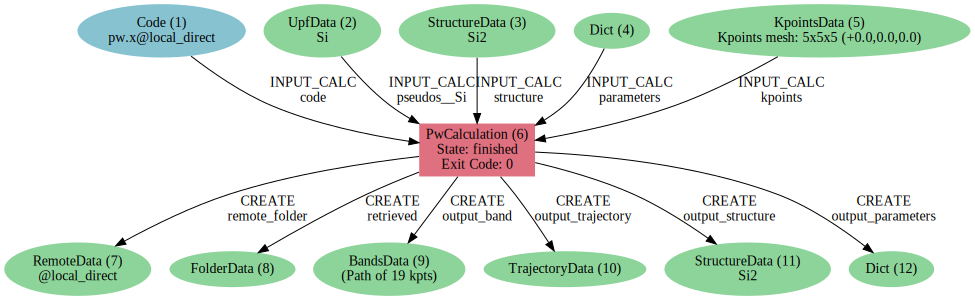

In [23]:
from aiida.tools.visualization import Graph

graph = Graph()
graph.add_incoming(output.node, annotate_links="both")
graph.add_outgoing(output.node, annotate_links="both")
graph.graphviz

In [64]:
query = aiida.orm.QueryBuilder()
query.append(aiida.orm.StructureData, tag="initial", project="*")
query.append(
    aiida.orm.CalcJobNode,
    filters={"attributes.process_state": "finished"},
    tag="calculation",
    with_incoming="initial",
    project="id",
)
query.append(
    aiida.orm.StructureData, tag="final", with_incoming="calculation", project="*"
)
query.dict()

[{'initial': {'*': <StructureData: uuid: 1980a2ad-f9b1-48d1-bf2b-b97922c95c7c (pk: 3)>},
  'calculation': {'id': 6},
  'final': {'*': <StructureData: uuid: 5ea8b2e2-d1de-4996-b19f-8df830a6618a (pk: 11)>}}]